# The Transformer encoder - _visualized_
This notebook accompanies the steps shown in the slides

In [24]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import torch
import tsensor
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from einops import rearrange, repeat

%matplotlib inline

In [25]:
np.random.seed(123)
torch.manual_seed(123)

In [26]:
embedding_dim = 6

## Input representation

The sentences we use:

In [27]:
sentences = [['She','likes','the','summer','better'], 
             ['He','loves','to','cook','healthy'],
             ['They','go','hiking','quite','often']]

The words we mask (0 stands for a masked word)

In [28]:
masked_words = [[1,0,0,1,1], # likes, the
                [1,1,1,0,1], # cook
                [1,1,1,1,0]] # often

In [29]:
n_sentences = len(sentences)
n_words_per_sentence = len(sentences[0])

In [30]:
list_of_words = [item for sublist in sentences for item in sublist]
sorted_words = np.sort(list_of_words)
vocab = {word:i for i,word in enumerate(sorted_words)}
vocab['MASK'] = 15;vocab

{'He': 0,
 'She': 1,
 'They': 2,
 'better': 3,
 'cook': 4,
 'go': 5,
 'healthy': 6,
 'hiking': 7,
 'likes': 8,
 'loves': 9,
 'often': 10,
 'quite': 11,
 'summer': 12,
 'the': 13,
 'to': 14,
 'MASK': 15}

We construct a as many embedding vectors of dimensionality `embedding_dim` as there are words in the vocabulary...

In [31]:
lookup_table = torch.nn.Embedding(len(vocab),embedding_dim=6);lookup_table(torch.tensor(0))

tensor([ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603],
       grad_fn=<EmbeddingBackward>)

Next step is to convert each word into the value it has in the `vocab` dict. The `lookup_table` needs to know which embeddings to look up for each word:

In [32]:
sentences = [['She','MASK','MASK','summer','better'], 
             ['He','loves','to','MASK','healthy'],
             ['They','go','hiking','quite','MASK']]

In [33]:
word_ids = torch.empty(size=(n_sentences,n_words_per_sentence),dtype=torch.long)
for i, sentence in enumerate(sentences):
    word_ids[i] = torch.tensor([vocab[word] for word in sentence])

In [34]:
word_ids

tensor([[ 1, 15, 15, 12,  3],
        [ 0,  9, 14, 15,  6],
        [ 2,  5,  7, 11, 15]])

Lookup the corresponding word representations (embeddings) and construct a tensor...

In [35]:
embedding_tensor = lookup_table(word_ids);embedding_tensor.shape

torch.Size([3, 5, 6])

Let's transform the `masked_words` list to a boolean tensor since we need it later:

In [36]:
print(masked_words)

[[1, 0, 0, 1, 1], [1, 1, 1, 0, 1], [1, 1, 1, 1, 0]]


In [37]:
masked_words= torch.tensor(masked_words,dtype=torch.bool);masked_words.shape

torch.Size([3, 5])

In [38]:
def vis_tensor(tnsr,dim=3):
    if dim == 3:
        tnsr = rearrange(tnsr,'b x y -> x y b')
    else:
        tnsr = rearrange(tnsr,'h b i j -> i j b h')
    with tsensor.explain():
        tnsr

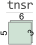

In [39]:
vis_tensor(embedding_tensor)

The word representation of the first word in the first sentence...

In [40]:
embedding_tensor[0,0]

tensor([-0.2196, -0.3792,  0.7671, -1.1925,  0.6984, -1.4097],
       grad_fn=<SelectBackward>)

The word representations of the first sentence...

In [41]:
embedding_tensor[0]

tensor([[-0.2196, -0.3792,  0.7671, -1.1925,  0.6984, -1.4097],
        [ 0.9031, -0.7218, -0.5951, -0.7112,  0.6230, -1.3729],
        [ 0.9031, -0.7218, -0.5951, -0.7112,  0.6230, -1.3729],
        [ 0.6716,  0.6933, -0.9487, -0.0765, -0.1526,  0.1167],
        [-0.1690,  0.9178,  1.5810,  1.3010,  1.2753, -0.2010]],
       grad_fn=<SelectBackward>)

## Positional encoding

The sequence of words within a sentence is important for any NLP task. However, the Transformer architecture by itself does not care about the actual order of words, i.e. you could switch words as you like and the final result would stay the same. To circumvent this _permutation invariance_, a tensor representing the position of each word and also the position of each scalar within the embedding is added to the actual embedding!

The idea is to imagine for each value of the embedding vector a sin/cos wave with a specific frequency. In order to compute the embedding vector say for 5th word, you just read for each value of the embedding vector the value of its sin/cos wave at position 5. I hope the visualisation below makes it more clear

In [42]:
# Code from https://www.tensorflow.org/tutorials/text/transformer
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates, angle_rates

def positional_encoding(position, d_model):
    angle_rads, angle_rates = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return pos_encoding, angle_rates

In [43]:
def vis_pos_enc(dim_positions, word_pos, emb_dim):
    fig, axs = plt.subplots(len(dim_positions), 1, sharex=True, figsize=(5,7))
    pos_encs, rates = positional_encoding(position=100, d_model=64)
    pos_encs = pos_encs[0]
        
    pos_enc_vec = []
    for i, ax in enumerate(axs.flat):
        rate = rates[0,dim_positions[i]]
        xs = np.arange(0, 100, 0.2)
        enc = pos_encs[word_pos,dim_positions[i]]
        is_sin = dim_positions[i]%2==0
        ax.plot(xs,np.sin(xs * rate) if is_sin else np.cos(xs * rate),color='grey', 
                label=f"{'sin' if is_sin else 'cos'}:{dim_positions[i]}",linestyle='-.' if is_sin else '-')
        ax.set_yticks([])
        ax.legend(loc='upper right')
        ax.axvline(x=word_pos,color='red')
        ax.plot([word_pos], [enc], marker='o', markersize=3, color="black")

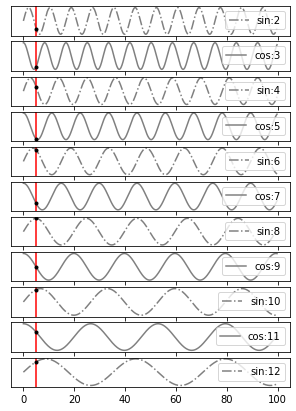

In [44]:
interact(vis_pos_enc, dim_positions=fixed(np.arange(13)[2:]), 
         word_pos=widgets.IntSlider(min=2, max=50, step=1, value=5), 
         emb_dim=fixed(64));

Note that due to the repeating patterns of both sin and cos waves, we are not restricted to sentences of specific lengths. 

We add the positional information to the `embedding_tensor`:

In [45]:
pos_enc_array = positional_encoding(position=n_words_per_sentence,d_model=embedding_dim)[0]
print(pos_enc_array.shape)

(1, 5, 6)


In [46]:
embedding_tensor = embedding_tensor + torch.tensor(pos_enc_array, dtype=torch.float32)

## Step 1: Generating attention weights

Instead of comparing the embedding vectors directly, the embeddings are first transformed using two linear layers. One such transformation generates the `query` tensor, the other transformation (with different weights) leads to the so-called `key` tensor. It helps in understanding if you think of both `query` and `key` as if it were the original `embedding_tensor`. In fact, you could also just skip these intermediate computations and I think they are mainly there to make the Transformer model more expressive (please correct me if I am wrong).

In [47]:
qkv_dim = 4
n_heads = 2

In [48]:
query_layer = torch.nn.Linear(embedding_dim, qkv_dim * n_heads)
key_layer = torch.nn.Linear(embedding_dim, qkv_dim * n_heads)

In [49]:
query = query_layer(embedding_tensor)
key = key_layer(embedding_tensor)

We rearrange this query tensor by splitting `qkv_dim * n_heads` into its subparts and then choosing `n_heads` as the first dimension, such that the resulting tensor has shape (`n_heads`, `batch_size`,`n_words`, `qkv_dim`)

In [50]:
query = rearrange(query,'b n_words (qkv_dim n_heads) -> n_heads b n_words qkv_dim', qkv_dim = qkv_dim)
key = rearrange(key,'b n_words (qkv_dim n_heads) -> n_heads b n_words qkv_dim', qkv_dim = qkv_dim)
print(query.shape)

torch.Size([2, 3, 5, 4])


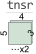

In [51]:
vis_tensor(query,dim=4)

For further illustration, let's just pick the first head of both `query` and `key`:

In [52]:
query_head1 = query[0]
key_head1 = key[0]

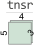

In [53]:
vis_tensor(query_head1)

Similarities among words are computed using _scaled dot-product distance_. But you can also think of cosine-similarity or other popular distance metrics.

In [54]:
score_tensor = torch.einsum('h b l d, h b k d -> h b l k', [query, key]) / np.sqrt(embedding_dim)

Let's just double check if we actually get the same result using `torch.bmm`. First we rearrange both `query` and `key` to be 3d tensors by "melting" head and batch dimension:

In [55]:
query_tmp = rearrange(query,'n_heads b n_words qkv_dim -> (n_heads b) n_words qkv_dim')
key_tmp = rearrange(key,'n_heads b n_words qkv_dim -> (n_heads b) qkv_dim n_words')

Compute the batch multiply and undo the changes -> get back the original shape in order to compare to `score_tensor`.

In [56]:
score_tensor2 = rearrange(torch.bmm(query_tmp, key_tmp),'(n_heads b) k l -> n_heads b k l', n_heads =n_heads)

In [57]:
torch.all(torch.eq(score_tensor2 / np.sqrt(embedding_dim),score_tensor))

tensor(True)

Now we take a closer look at the first head tensor which contain a first set of attention scores:

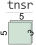

In [58]:
scores_head1 = score_tensor[0]
vis_tensor(scores_head1)

In [59]:
first_sentence_attn_scores = scores_head1[0];first_sentence_attn_scores

tensor([[ 0.0519, -0.3873, -0.5150, -0.1944,  0.6491],
        [ 0.0228,  0.1244, -0.0129,  0.1628,  0.1411],
        [-0.0237,  0.2960,  0.2174,  0.2838, -0.1070],
        [ 0.0548,  0.3601,  0.3619,  0.0879, -0.6533],
        [ 0.1409, -0.5592, -0.6833, -0.4429,  0.6549]],
       grad_fn=<SelectBackward>)

Each row in `first_sentence_attn_scores` corresponds to a word _w_ and the respective values in row _w_ depict the similarities of the other words with respect to _w_

What is not clear to me is why we actually need both `query` and `key` and not only a `query` tensor? Below I use cosine-similarity with only a `query` tensor which would also make sense wouldn't it?

In [60]:
def attn_cosine_similarity(x):
    a = x/x.norm(dim=3).unsqueeze(3)
    b = x/x.norm(dim=3).unsqueeze(3)
    out = torch.einsum('h b l d, h b k d -> h b l k', [a, b])
    out[out != out] = 0.
    return out

In [61]:
first_sentence_attn_scores_cos = attn_cosine_similarity(query)[0][0]; first_sentence_attn_scores_cos

tensor([[ 1.0000,  0.4236,  0.0834, -0.6318,  0.7363],
        [ 0.4236,  1.0000,  0.9169,  0.2008,  0.0863],
        [ 0.0834,  0.9169,  1.0000,  0.3286, -0.3157],
        [-0.6318,  0.2008,  0.3286,  1.0000, -0.2342],
        [ 0.7363,  0.0863, -0.3157, -0.2342,  1.0000]],
       grad_fn=<SelectBackward>)

We will use the computed scores contained in `score_tensor` to weight each of the word embeddings. The word with the highest score gets the most attention, i.e. is weighted the highest. Since we do not know some words (the ones we masked at the beginning) we also should not user their scores. To accomplish this, first think about how to we can transform the scores into proper weights such that they sum up to 1. We apply the softmax activation across columns after we set the scores of the masked words to high negative numbers. Here we have to take extra care to not mess up with the masking...

In [62]:
print(masked_words.shape)
print(score_tensor.shape)

torch.Size([3, 5])
torch.Size([2, 3, 5, 5])


In [63]:
masked_words

tensor([[ True, False, False,  True,  True],
        [ True,  True,  True, False,  True],
        [ True,  True,  True,  True, False]])

We have to rearrange `masked_words` to have the same number of dimensions as `score_tensor` to enable broadcasting. 

torch.Size([1, 3, 1, 5])


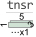

In [64]:
masked_words_re = rearrange(masked_words,'b n_words -> () b () n_words')
print(masked_words_re.shape)
vis_tensor(masked_words_re,dim=4)

We apply the (inverted) `masked_words_re` tensor to `score_tensor` and fill the masked words with `-np.inf` (we could also use a high negative number as in the slides): 

In [65]:
masked_score_tensor = score_tensor.masked_fill(~masked_words_re, -np.inf); masked_score_tensor

tensor([[[[ 0.0519,    -inf,    -inf, -0.1944,  0.6491],
          [ 0.0228,    -inf,    -inf,  0.1628,  0.1411],
          [-0.0237,    -inf,    -inf,  0.2838, -0.1070],
          [ 0.0548,    -inf,    -inf,  0.0879, -0.6533],
          [ 0.1409,    -inf,    -inf, -0.4429,  0.6549]],

         [[-0.0895, -0.1916,  0.1653,    -inf, -0.3235],
          [ 0.3065,  0.7526, -0.1312,    -inf, -0.7490],
          [-0.0160, -0.1785,  0.2377,    -inf, -0.2758],
          [ 0.1676,  0.0526,  0.1889,    -inf,  0.0744],
          [-0.0971, -0.6564,  0.2371,    -inf,  0.6967]],

         [[ 1.3640, -0.8041, -0.4320,  0.2330,    -inf],
          [-1.4062,  0.4053,  0.1687, -1.3295,    -inf],
          [ 0.5450, -0.0487,  0.1263,  0.0475,    -inf],
          [-0.9276,  0.0295, -0.0334, -1.2410,    -inf],
          [-0.2831,  0.1936,  0.0576, -0.1232,    -inf]]],


        [[[ 0.1403,    -inf,    -inf, -0.1126, -0.0733],
          [ 0.0201,    -inf,    -inf, -0.0374, -0.0592],
          [ 0.0807,    

In [66]:
attn_weight_tensor = torch.nn.functional.softmax(masked_score_tensor,dim=3)

In [67]:
first_sentence_attn_weights = attn_weight_tensor[0][0]; first_sentence_attn_weights # first head, first sentence

tensor([[0.2779, 0.0000, 0.0000, 0.2172, 0.5049],
        [0.3053, 0.0000, 0.0000, 0.3511, 0.3436],
        [0.3049, 0.0000, 0.0000, 0.4146, 0.2805],
        [0.3958, 0.0000, 0.0000, 0.4092, 0.1950],
        [0.3096, 0.0000, 0.0000, 0.1727, 0.5177]], grad_fn=<SelectBackward>)

## Step II: Generating weighted word representations

What's still missing is to actually weight the words (word-embeddings) with the computed attention weights. Here, again, we do not weight the original embedding vectors but a transformation in form of a so-called `value` tensor. The `value` tensor is computed exactly like `query` and `key` (although it can have a different dimensionality). 

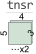

In [68]:
value_layer = torch.nn.Linear(embedding_dim, qkv_dim * n_heads, bias=False) # Notice the name qkv_dim
value = value_layer(embedding_tensor)
value = rearrange(value,'b n_words (qkv_dim n_heads) -> n_heads b n_words qkv_dim', qkv_dim = qkv_dim)
vis_tensor(value,dim=4)

We can now compute the weighted embeddings (and again, not the real embeddings but linearly transformed ones) using `attn_weight_tensor` and `value` tensor:

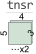

In [69]:
weighted_value = torch.einsum('hblt,hbtv->hblv', [attn_weight_tensor, value]);vis_tensor(weighted_value,dim=4)

We are almost done! But still, what we want to achieve in the end is to have a tensor that has the same shape as our `embedding_tensor` we started with, only that the embedding for each word should know about its sourrounding words, i.e. a weighted embedding. So we want to go from `value` shape to `embedding_tensor` shape:

In [70]:
f'from {value.shape} -> {embedding_tensor.shape}'

'from torch.Size([2, 3, 5, 4]) -> torch.Size([3, 5, 6])'

Notice that by using a linear transformation (linear layer) again, we can alter the last dimension. So we can do the following:

In [71]:
f'from {value.shape} -> 3, 5, (2*4) -> linear -> {embedding_tensor.shape}'

'from torch.Size([2, 3, 5, 4]) -> 3, 5, (2*4) -> linear -> torch.Size([3, 5, 6])'

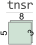

In [72]:
reshaped_weighted_value = rearrange(weighted_value, 'n_heads b n_words qkv_dim -> b n_words (n_heads qkv_dim)')
vis_tensor(reshaped_weighted_value)

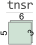

In [73]:
to_original = torch.nn.Linear(n_heads * qkv_dim, embedding_dim)
weighted_embedding_tensor = to_original(reshaped_weighted_value)
vis_tensor(weighted_embedding_tensor)

Pretty cool! Since we might have lost some information about the word embeddings themselves (`embedding_tensor`), we can add them back in again. 

In [74]:
weighted_embedding_tensor = weighted_embedding_tensor + embedding_tensor; weighted_embedding_tensor[0]

tensor([[-0.4647,  0.6697,  0.8663, -0.4865,  0.5267, -0.3121],
        [ 1.5732, -0.1808, -0.4681, -0.0126,  0.4392, -0.2777],
        [ 1.6621, -1.1677, -0.4384, -0.0086,  0.4330, -0.2651],
        [ 0.6995, -0.3092, -0.7494,  0.6220, -0.3530,  1.2224],
        [-1.1651,  0.3405,  1.8940,  1.9758,  1.1110,  0.8676]],
       grad_fn=<SelectBackward>)

### Layer normalization

Do some normalization with each weighted embedding such that each embedding has mean 0 and standard deviation 1.

In [75]:
layer_norm = torch.nn.LayerNorm(normalized_shape=embedding_dim)
weighted_embedding_tensor = layer_norm(weighted_embedding_tensor)
print(weighted_embedding_tensor[0].mean(dim=1).round())
print(weighted_embedding_tensor[0].std(dim=1).round())

tensor([-0., 0., 0., 0., -0.], grad_fn=<RoundBackward>)
tensor([1., 1., 1., 1., 1.], grad_fn=<RoundBackward>)


## Step III: Position-wise feed forward

Other than in the slides, we will skip the position-wise feed-forward part here, since it is basically just yet another non-linear transformation of `weighted_embedding_tensor`. 

## Step IV: Predict masked words

Finally, we can have one last layer which maps from embedding dimensionality to vocab_size (total number of words/tokens). 

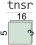

In [76]:
vocab_layer = torch.nn.Linear(embedding_dim, len(vocab))
output = torch.nn.functional.softmax(vocab_layer(weighted_embedding_tensor),dim=2)
vis_tensor(output)

Let's take a closer look at the values for the second word in the first sentence, which is the masked word _likes_:

In [77]:
output[0][1]

tensor([0.0634, 0.0247, 0.0923, 0.0259, 0.0818, 0.0395, 0.0198, 0.0966, 0.0251,
        0.0333, 0.0433, 0.0751, 0.0960, 0.0421, 0.1207, 0.1204],
       grad_fn=<SelectBackward>)

Each of these value can be interpreted as the probability that a weighted embedding corresponds to a word. We hope that after training such a model, the value at position 8 is the highest..

In [78]:
vocab["likes"]

8

Speaking of training such a model, let's have a look at a pretrained one...

In [79]:
from transformers import BertTokenizer, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [80]:
sentence = "she [MASK] the summer better"
input_ids = tokenizer.encode(sentence, return_tensors="pt",add_special_tokens=True)

In [81]:
logits = model(input_ids)[0];logits.shape

torch.Size([1, 7, 30522])

In [82]:
token_id = torch.argmax(torch.nn.functional.softmax(logits[:,2,:], dim=1))
tokenizer.convert_ids_to_tokens(token_id.item())

'liked'

I hope you enjoyed this tutorial. I you have any questions/suggestions/remarks, let me know ;-). 